# Assignment 5: Tracking of a moving object which trajectory is disturbed by random acceleration

## Team №6:
1. Angelina Prokopeva
2. Nikita Gorbadey
3. Mark Griguletskii
4. Stanislav Savushkin

03.10.2019, Skoltech

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import Image
import os

if not os.path.exists("images"):
    os.mkdir("images")

In [2]:
generate_report = False
def plot(trace_num, x_data, y_data, xlable = 'xlable', ylable = 'ylable',
                legend = 'legend', title = 'title', mode='lines'):
    plot.counter += 1
    fig_name = 'images/' + str(plot.counter) + '.jpg'
    fig = go.Figure()
    for i in range(trace_num):
        fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode=mode, name=legend[i], showlegend = True))
    fig.update_layout(
        title=go.layout.Title(
            text=title,
        ),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
                text=xlable
            )
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
                text=ylable
            )
        )
    )
    if generate_report is True:
        fig.write_image(fig_name)
        display(Image(fig_name))
    else:
        fig.show()
plot.counter = 0

### Working progress

In [3]:
def motion_tragectory(size, T, sigma_a, X_init=0, V_init=0):
    "Function for generating motion trajectory with normally distributed random acceleration"
    out = np.zeros(size)
    V = np.zeros(size)
    out[0] = X_init
    V[0] = V_init
    a = np.random.normal(loc=0, scale=sigma_a, size=size)
    for i in range(1, size):
        V[i] = V[i-1] + a[i-1]*T
        out[i] = out[i-1] + V[i-1]*T + (a[i-1]*T**2)/2
    return out

In [4]:
def measured_trajectory(data, sigma):
    "Supplementary function for generating measured trajectory"
    return np.add(data, np.random.normal(loc=0, scale=sigma, size=data.size))

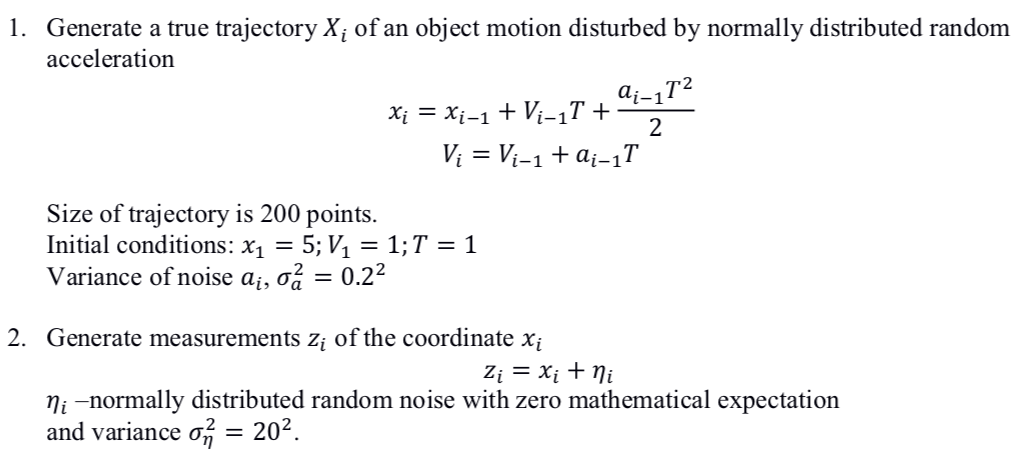

**Generating a true trajectory 𝑋𝑖 and its measurements of an object motion disturbed by normally distributed random acceleration with given parameters**

In [5]:
N = 200
X_init = 5
V_init = 1
T = 1
sigma_a = 0.2
sigma_n = 20

# Generating true trajectory
x = motion_tragectory(N, T, sigma_a, X_init=X_init, V_init=V_init)

# Generating measurements
z = measured_trajectory(x, sigma_n)
num_points = np.linspace(1, N, num=N)

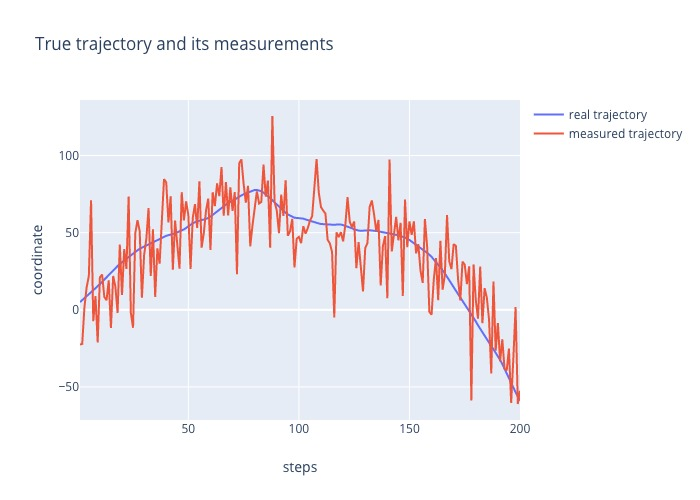

In [6]:
plot(2, [num_points, num_points], [x, z], title='True trajectory and its measurements', xlable='steps', ylable='coordinate',
     legend=['real trajectory', 'measured trajectory'])

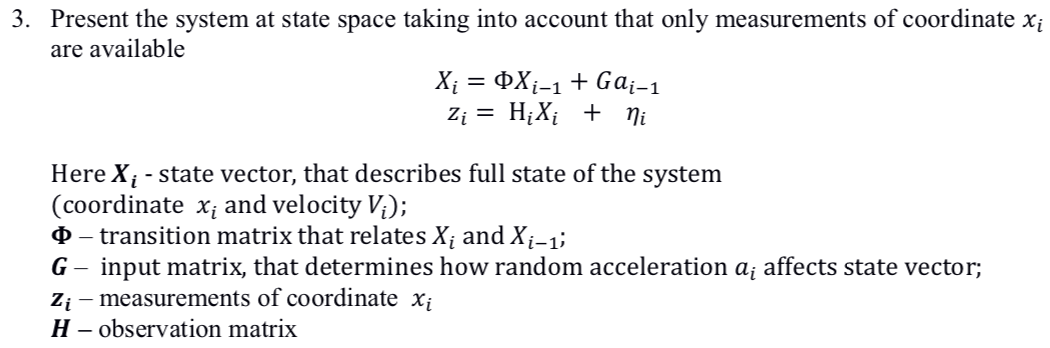

**4. Develop Kalman filter algorithm to estimate state vector 𝑋𝑖**

In [7]:
def kalman_filter(z, T, X_0=[0, 0], P_0=[[100, 0], [0, 100]], sigma_a=1, sigma_n=1, shift=7):
    shape = (z.size, 2)
    X_pred = np.zeros(shape)
    X_filt = np.zeros(shape)
    x_i_pred = np.zeros(shape[0])
    F = np.array([[1, T], [0, 1]])
    G = np.array([T**2/2, T]).T
    H = np.array([1, 0])
    X_0 = [2, 0]
    P_0_0 = [[10000, 0], [0, 10000]]
    
    # prepare parameters
    Q = G.dot(G.T.dot(sigma_a**2))
    R = sigma_n**2
    P_pred = np.zeros((shape[0], 2, 2))
    P_filt = np.zeros((shape[0], 2, 2))
    K = np.zeros(shape)

    X_filt[0] = X_0
    P_filt[0] = P_0
    K[0] = P_filt[0].dot(H.T)/(H.dot(P_filt[0]).dot(H.T) + R)

    for i in range(1, shape[0]):
        # Make prediction
        X_pred[i] = F.dot(X_filt[i-1])
        P_pred[i] = np.dot(F, np.dot(P_filt[i-1], F.T)) + Q

        # Make filtration
        K[i] = P_pred[i].dot(H.T)/(H.dot(P_pred[i]).dot(H.T) + R)
        X_filt[i] = X_pred[i] + K[i]*(z[i] - H.dot(X_pred[i]))
        P_filt[i] = (np.eye(shape[1]) - np.outer(K[i], H)).dot(P_pred[i])
        
    x_i_pred = np.roll(np.linalg.matrix_power(F, shift).dot(X_filt.T)[0], shift)
    x_i_pred[:shift] = X_0[0]

    return X_filt, X_pred, K, P_filt, x_i_pred

**5. Plot results including true trajectory, measurements, filtered estimates of state vector 𝑋𝑖. Run filter several times to see that estimation results are different with every new trajectory.**

In [8]:
kalman_data = kalman_filter(z, T=1, X_0=[2, 0], P_0=[[10000, 0], [0, 10000]], sigma_a=sigma_a, sigma_n=sigma_n)

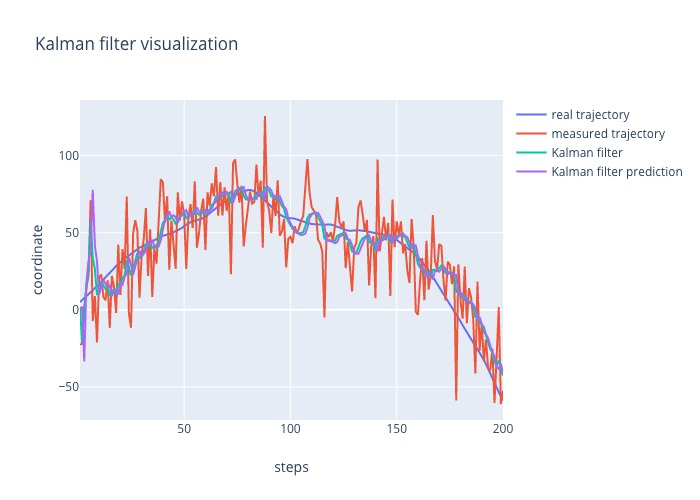

In [9]:
plot(4, [num_points, num_points, num_points, num_points], [x, z, kalman_data[0][:,0], kalman_data[1][:,0]], title='Kalman filter visualization', xlable='steps', ylable='coordinate',
     legend=['real trajectory', 'measured trajectory', 'Kalman filter', 'Kalman filter prediction'])

From the plot we can see that kalman filter works good. The final estimation is almost always between prediction points and true trajectory.

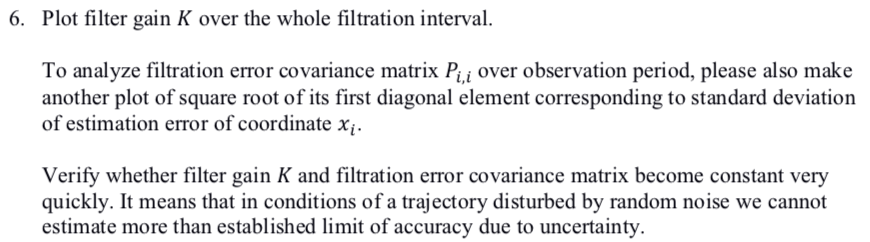

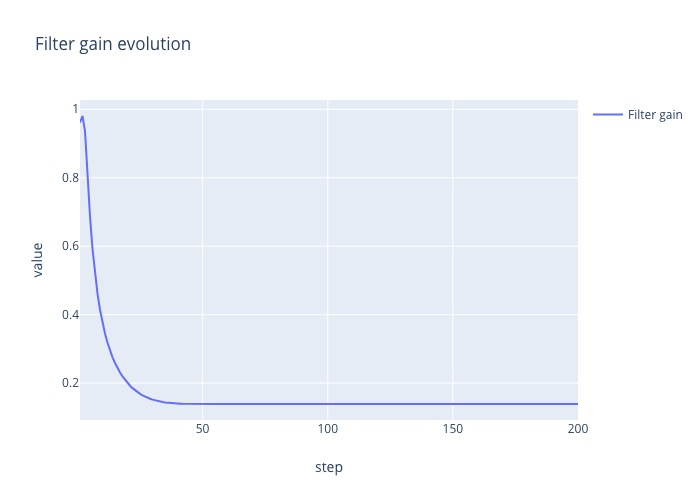

In [10]:
plot(1, [num_points], [kalman_data[2][:,0]], title='Filter gain evolution', xlable='step', ylable='value',
     legend=['Filter gain'])

From the plot we can see that filter gain approaches constant value very quickly. Filter gain is constant value above zero, which means that we are limited in accuracy because of state noise of our process

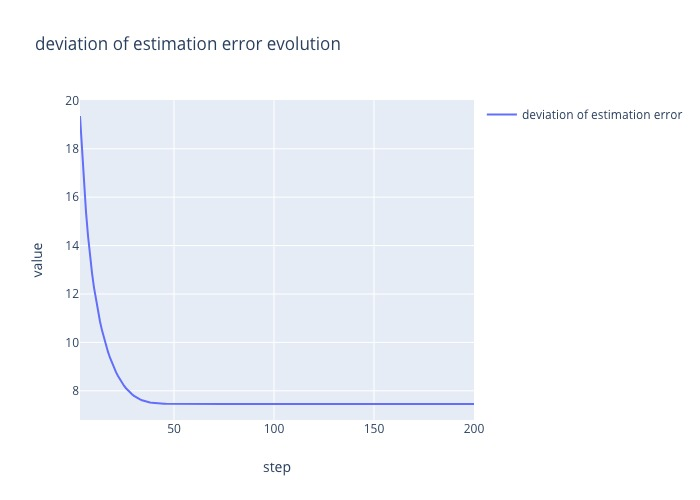

In [11]:
# Calculation of standard deviation of estimation error of coordinate 𝑥𝑖.
x_deviation = np.sqrt(kalman_data[3][:,0,0])
plot(1, [num_points[2:]], [x_deviation[2:]], title='deviation of estimation error evolution', xlable='step', ylable='value',
     legend=['deviation of estimation error'])

From the plot we can see that filtration error covariance matrix become constant very quickly

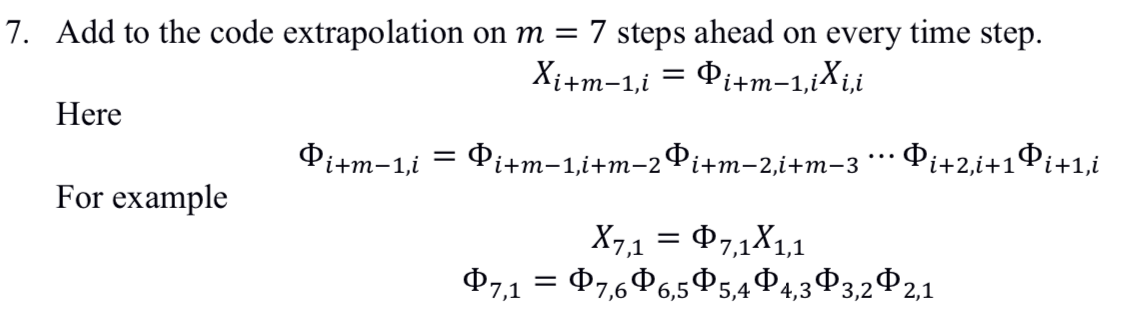

In [12]:
F = np.array([[1, T], [0, 1]])
x_7_pred = np.roll(np.linalg.matrix_power(F, 7).dot(kalman_data[0].T)[0], 7)
x_7_pred[:7] = 10

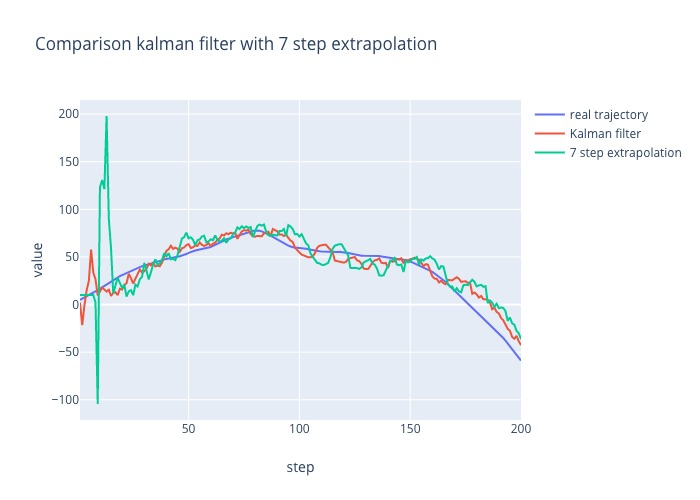

In [13]:
plot(3, [num_points, num_points, num_points,], [x, kalman_data[0][:,0], x_7_pred], title='Comparison kalman filter with 7 step extrapolation',
     xlable='step', ylable='value',
     legend=['real trajectory', 'Kalman filter', '7 step extrapolation'])

From the plot we can see that 7 steps ahead extrapolation is very inaccurate in the beginning, when the filter gain is still not constant and after that becomes shifted from the real trajectory

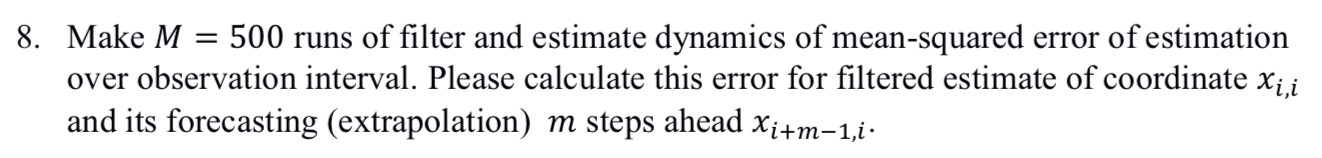

In [14]:
def error_calculation(runs=500, steps=200, T=1, sigma_a=0.2, X_init=0, V_init=0,
                         X_0=[2, 0], P_0=[[10000, 0], [0, 10000]], sigma_n=20, shift=7, sigma_a_filter=0.2):
    err_filt = np.zeros(steps)
    err_filt_pred = np.zeros(steps-shift)
    
    for i in range(runs):
        # Generating true trajectory
        x = motion_tragectory(steps, T, sigma_a=sigma_a, X_init=X_init, V_init=V_init)
        
        # Generating measurements
        z = measured_trajectory(x, sigma_n)
        
        # Perform Kalman filter
        X_filt, X_pred, K, P_filt, x_i_pred = kalman_filter(z, T=T, X_0=X_0, P_0=P_0, 
                                                            sigma_a=sigma_a_filter, sigma_n=sigma_n, shift=shift)
        
        # Calculate errors starting from 3rd step
        err_filt += (x - X_filt[:,0])**2
        err_filt_pred += (x_i_pred[shift:] - x[shift:])**2
    
    # Take square root for each step
    err_filt = np.sqrt(err_filt / (runs - 1))
    err_filt_pred = np.sqrt(err_filt_pred / (runs - 1))
    
    return err_filt, err_filt_pred

Perform error calculation starting from 3rd point

In [15]:
M = 500
N = 200
steps = np.linspace(2, N-2)

err_filt, err_filt_pred = error_calculation(P_0=[[10000, 0], [0, 10000]])

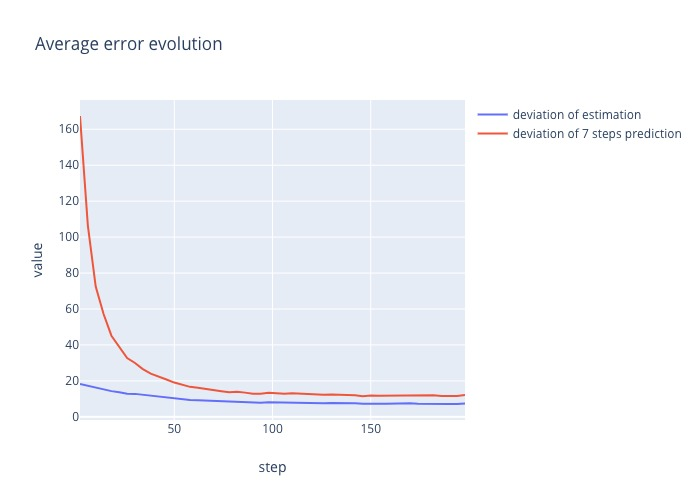

In [16]:
plot(2, [steps, steps], [err_filt[2:], err_filt_pred[2:]], title='Average error evolution',
     xlable='step', ylable='value',
     legend=['deviation of estimation', 'deviation of 7 steps prediction'])

We can see that that after some step both filters become stationary. For the 7 step forward extrapolation the initial error is much bigger, it becomes constant later than estimation and its final deviation is slightly bigger because of forward shift.

**9. Compare mean-squared error of filtered estimate of coordinate 𝑥𝑖,𝑖 with standard deviation of measurement errors. Make conclusions about effectiveness of filtration.**

Mean squared error for estimation quickly becomes around 7.3, and for 7-step forward prediction - 11.7. Meanwhile, standard deviation of measurement errors is sigma_n=20, so both methods give better accuracy than measurements, that's why both filters are effective.

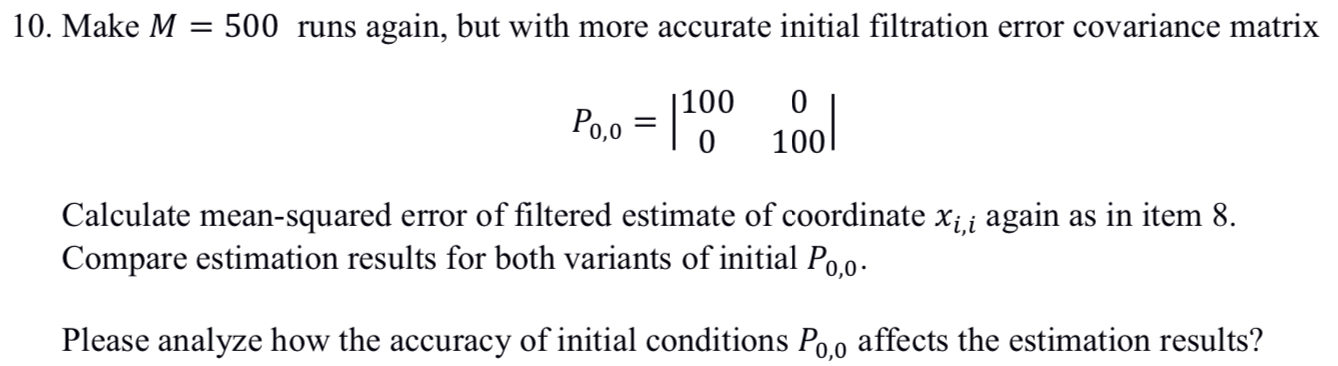

In [17]:
err_filt_accurate, err_filt_pred_accurate = error_calculation(P_0=[[100, 0], [0, 100]])

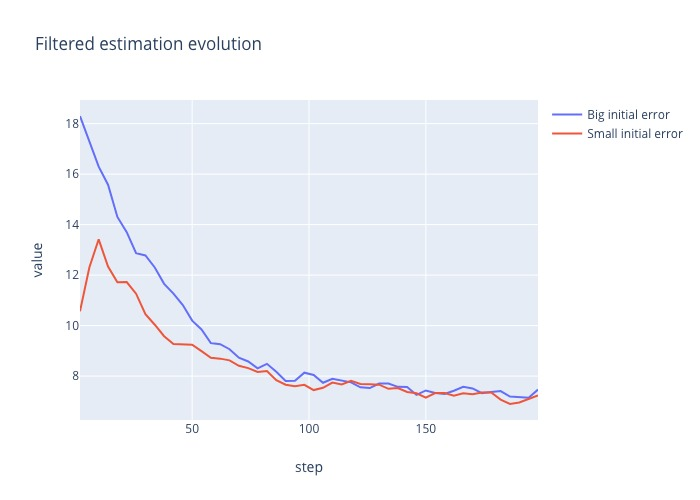

In [18]:
plot(2, [steps, steps], [err_filt[2:], err_filt_accurate[2:]],title='Filtered estimation evolution',
     xlable='step', ylable='value', legend=['Big initial error', 'Small initial error'])

From the plot we can see that if we put more accurate initial error covariance matrix, the filtration becomes stationary faster. The choice of initial condition doesn't affect estimation results when the the initial error covariance matrix is lower than the real value (in our case sqrt((x[0] - z[0])^2) = sqrt((5-2)^2)

**11. Compare calculation errors of estimation 𝑃 provided Kalman filter algorithm with true estimation errors.**

In [19]:
kalman_data = kalman_filter(z, T=1, X_0=[2, 0], P_0=[[10000, 0], [0, 10000]], sigma_a=sigma_a, sigma_n=sigma_n)
filt_err = np.sqrt(kalman_data[3][:,0,0])
true_err = error_calculation(P_0=[[10000, 0], [0, 10000]])

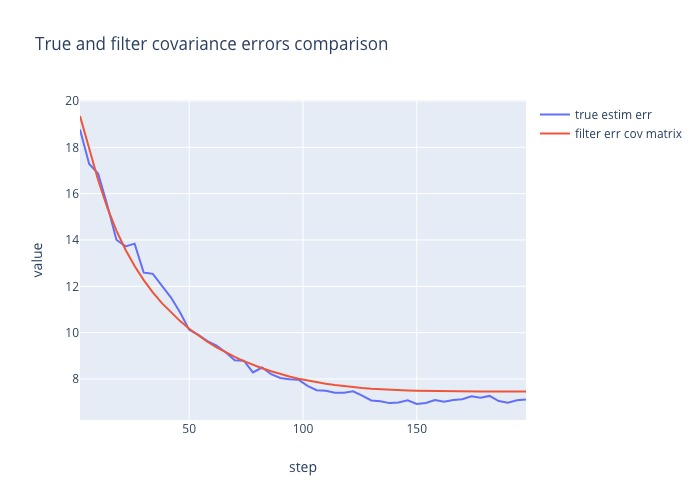

In [20]:
plot(2, [steps, steps], [true_err[0][2:], filt_err[2:]],title='True and filter covariance errors comparison',
     xlable='step', ylable='value', legend=['true estim err', 'filter err cov matrix'])

From the plot we can see that calculation errors of estimation correspond to true estimation errors.

**12. Run filter for deterministic trajectory (no random disturbance). Make 𝑀 = 500 runs and verify**

In [21]:
N = 200
X_init = 5
V_init = 1
T = 1
sigma_a = 0
sigma_n = 20

# Generating true trajectory
x = motion_tragectory(N, T, sigma_a, X_init=X_init, V_init=V_init)

# Generating measurements
z = measured_trajectory(x, sigma_n)

# Perform kalman filtration
kalman_data = kalman_filter(z, T=1, X_0=[2, 0], P_0=[[100, 0], [0, 100]], sigma_a=sigma_a, sigma_n=sigma_n)

# True estimation errors calculation
filt_err = np.sqrt(kalman_data[3][:,0,0])

# Filtration error calculation
true_err = error_calculation(P_0=[[100, 0], [0, 100]], sigma_a=sigma_a, sigma_a_filter=sigma_a)

kalman_gain = kalman_data[2][:,0]
steps = np.linspace(2, N, N-1)

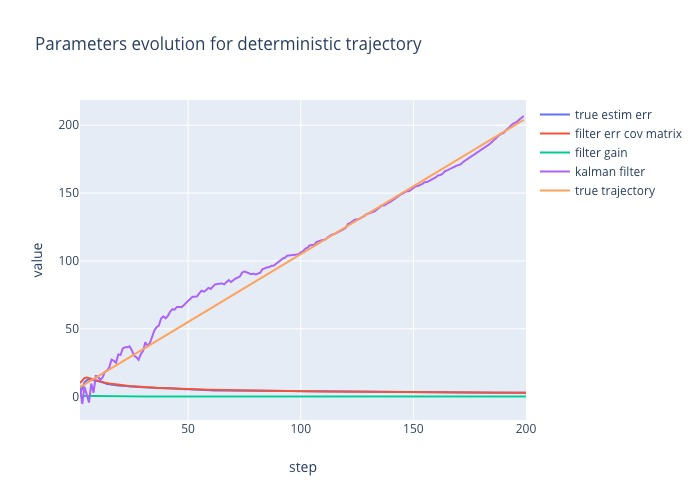

In [22]:
plot(5, [steps, steps, steps, steps, steps], [true_err[0], filt_err, kalman_gain, kalman_data[0][2:,0], x[2:]],
     title='Parameters evolution for deterministic trajectory',
     xlable='step', ylable='value',
     legend=['true estim err', 'filter err cov matrix', 'filter gain', 'kalman filter', 'true trajectory'])

From the plot we can see that filter gain and both filtration error and true estimation error approach to zero. That means that after some step Kalman filter almost no more rely on measurements but on its estimations.

**13. Verify what happens if you use deterministic model of motion, but in fact motion is disturbed by random acceleration.**

In [23]:
sigma_a = 0.2

# Generating true trajectory
x = motion_tragectory(N, T, sigma_a, X_init=X_init, V_init=V_init)

# Generating measurements
z = measured_trajectory(x, sigma_n)

# Perform kalman filtration
kalman_data = kalman_filter(z, T=1, X_0=[2, 0], P_0=[[100, 0], [0, 100]], sigma_a=0, sigma_n=sigma_n)

# True estimation errors calculation
filt_err = np.sqrt(kalman_data[3][:,0,0])

# Filtration error calculation
true_err = error_calculation(P_0=[[100, 0], [0, 100]], sigma_a=sigma_a, sigma_a_filter=0)

kalman_gain = kalman_data[2][:,0]
steps = np.linspace(2, N, N-1)

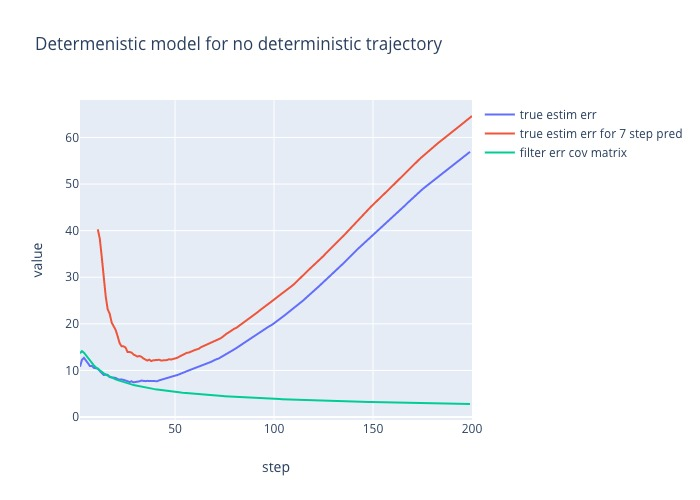

In [24]:
plot(3, [steps, steps[9:], steps], [true_err[0][2:], true_err[1][2:], filt_err[2:]],
     title='Determenistic model for no deterministic trajectory',
     xlable='step', ylable='value',
     legend=['true estim err', 'true estim err for 7 step pred', 'filter err cov matrix'])

Here we can see that if we neglect state noize in Kalman filter it will lead to divergence. However the filter error estimation is small and filter "thinks" that variance of coordinate estimation error approaches to zero. We can conclude that Kalman filter doesn't work if we use deterministic model for no deterministic trajectory. 

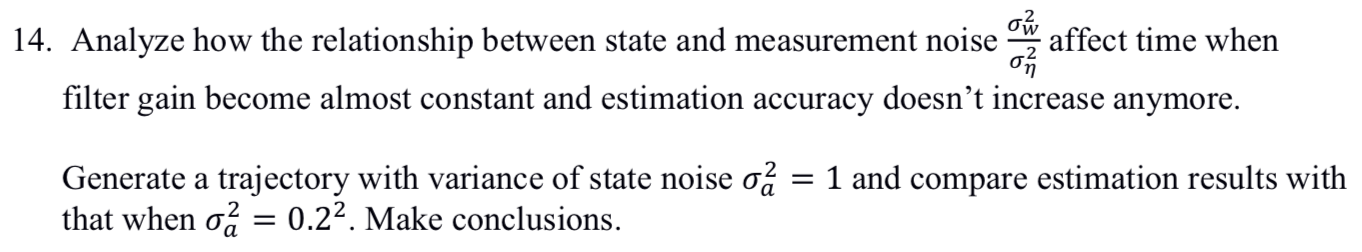

In [25]:
sigma_a = 1
# Generating true trajectory
x = motion_tragectory(N, T, sigma_a, X_init=X_init, V_init=V_init)

# Generating measurements
z = measured_trajectory(x, sigma_n)

# Perform kalman filtration
kalman_data = kalman_filter(z, T=1, X_0=[2, 0], P_0=[[100, 0], [0, 100]], sigma_a=sigma_a, sigma_n=sigma_n)
K1 = kalman_data[2]

sigma_a = 0.2
# Generating true trajectory
x = motion_tragectory(N, T, sigma_a, X_init=X_init, V_init=V_init)

# Generating measurements
z = measured_trajectory(x, sigma_n)

# Perform kalman filtration
kalman_data = kalman_filter(z, T=1, X_0=[2, 0], P_0=[[100, 0], [0, 100]], sigma_a=sigma_a, sigma_n=sigma_n)
K2 = kalman_data[2]

num_points = np.linspace(1, N, num=N)

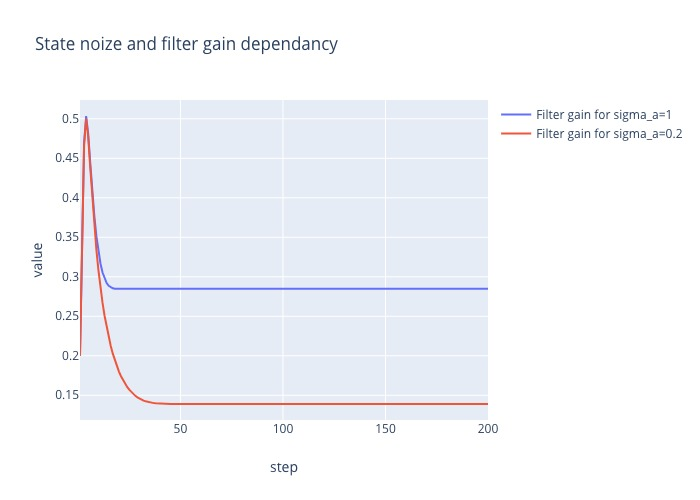

In [26]:
plot(2, [num_points, num_points], [K1[:,0], K2[:,0]], title='State noize and filter gain dependancy',
     xlable='step', ylable='value', legend=['Filter gain for sigma_a=1', 'Filter gain for sigma_a=0.2'])

From the plot we can see that the bigger the state noise - the faster filter gain approaches to constant value. Moreover, when state noize smaller, filter gain is smaller, which corresponds to the fact that when the system is more deterministic, filter more rely on its predictions than on measurements

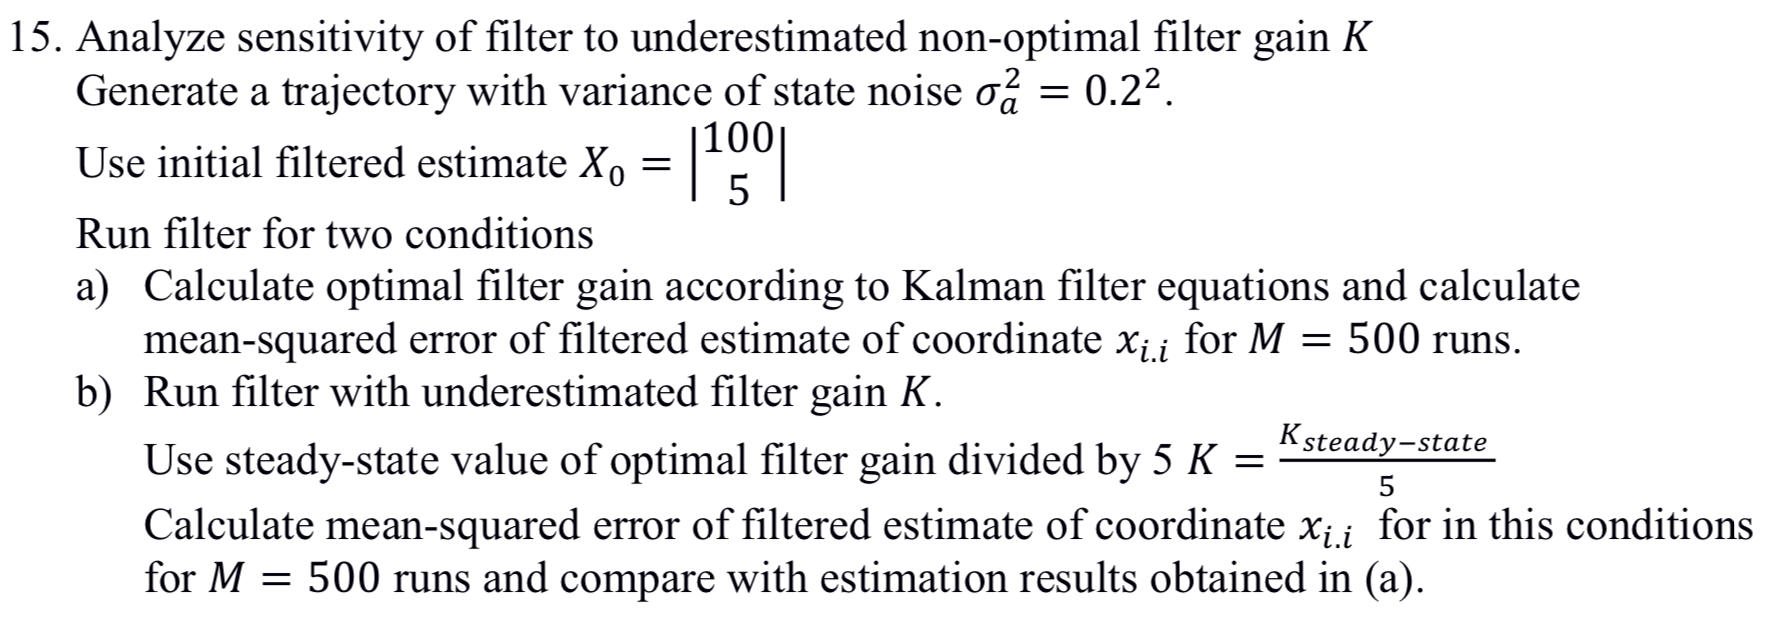

a)

In [27]:
sigma_a = 0.2
# Generating true trajectory
x = motion_tragectory(N, T, sigma_a, X_init=X_init, V_init=V_init)

# Generating measurements
z = measured_trajectory(x, sigma_n)

# Perform kalman filtration
kalman_data = kalman_filter(z, T=1, X_0=[100, 5], P_0=[[100, 0], [0, 100]], sigma_a=sigma_a, sigma_n=sigma_n)
K = kalman_data[2]
print('Optimal filter gain is K_opt = [{:2f}, {:2f}]'.format(K[:, 0][-1], K[:, 1][-1]))

Optimal filter gain is K_opt = [0.138952, 0.010375]


In [28]:
true_err = error_calculation(sigma_a=0.2, sigma_a_filter=0.2, X_0=[100, 5])

b)

In [29]:
def kalman_filter_steady(z, T, X_0=[0, 0], P_0=[[100, 0], [0, 100]], sigma_a=1, sigma_n=1, shift=7):
    shape = (z.size, 2)
    X_pred = np.zeros(shape)
    X_filt = np.zeros(shape)
    x_i_pred = np.zeros(shape[0])
    F = np.array([[1, T], [0, 1]])
    G = np.array([T**2/2, T]).T
    H = np.array([1, 0])
    X_0 = [2, 0]
    P_0_0 = [[10000, 0], [0, 10000]]
    
    # prepare parameters
    Q = G.dot(G.T.dot(sigma_a**2))
    R = sigma_n**2
    P_pred = np.zeros((shape[0], 2, 2))
    P_filt = np.zeros((shape[0], 2, 2))
    K_state = [0.138952/5, 0.010375/5]
    K = np.array(K_state)

    X_filt[0] = X_0
    P_filt[0] = P_0

    for i in range(1, shape[0]):
        # Make prediction
        X_pred[i] = F.dot(X_filt[i-1])
        P_pred[i] = np.dot(F, np.dot(P_filt[i-1], F.T)) + Q

        # Make filtration
        X_filt[i] = X_pred[i] + K*(z[i] - H.dot(X_pred[i]))
        P_filt[i] = (np.eye(shape[1]) - np.outer(K, H)).dot(P_pred[i])
        
    x_i_pred = np.roll(np.linalg.matrix_power(F, shift).dot(X_filt.T)[0], shift)
    x_i_pred[:shift] = X_0[0]

    return X_filt, X_pred, K, P_filt, x_i_pred

In [30]:
def error_calculation_constant_gain(runs=500, steps=200, T=1, sigma_a=0.2, X_init=0, V_init=0,
                         X_0=[2, 0], P_0=[[10000, 0], [0, 10000]], sigma_n=20, shift=7, sigma_a_filter=0.2):
    err_filt = np.zeros(steps)
    err_filt_pred = np.zeros(steps-shift)
    
    for i in range(runs):
        # Generating true trajectory
        x = motion_tragectory(steps, T, sigma_a=sigma_a, X_init=X_init, V_init=V_init)
        
        # Generating measurements
        z = measured_trajectory(x, sigma_n)
        
        # Perform Kalman filter
        X_filt, X_pred, K, P_filt, x_i_pred = kalman_filter_steady(z, T=T, X_0=X_0, P_0=P_0, 
                                                            sigma_a=sigma_a_filter, sigma_n=sigma_n, shift=shift)
        
        # Calculate errors starting from 3rd step
        err_filt += (x - X_filt[:,0])**2
        err_filt_pred += (x_i_pred[shift:] - x[shift:])**2
    
    # Take square root for each step
    err_filt = np.sqrt(err_filt / (runs - 1))
    err_filt_pred = np.sqrt(err_filt_pred / (runs - 1))
    
    return err_filt, err_filt_pred

In [31]:
true_err_constant_gain = error_calculation_constant_gain(sigma_a=0.2, sigma_a_filter=0.2, X_0=[100, 5])

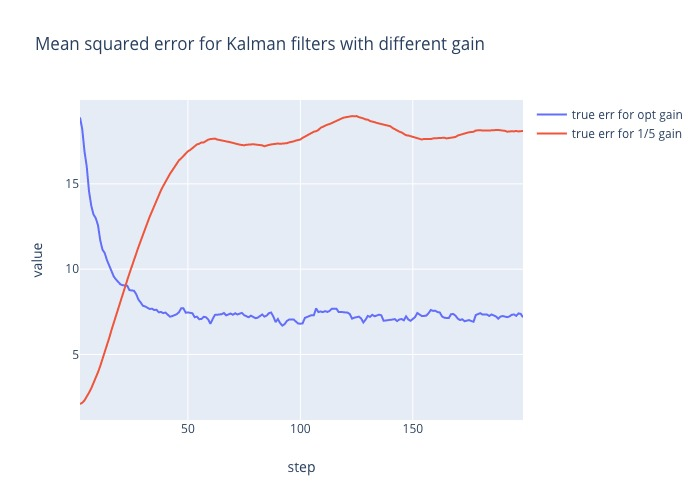

In [32]:
plot(2, [steps, steps], [true_err[0][2:], true_err_constant_gain[0][2:]],
     title='Mean squared error for Kalman filters with different gain',
     xlable='step', ylable='value', legend=['true err for opt gain', 'true err for 1/5 gain'])

From the plot we can see that if we take underestimated constant filter gain, the mean squared error is much higher, the value of error variance is about the same as measurements noise, so there is no filtration.

### Conclusion

In this lab we practised with Kalman filter. We learnt under which condition filter perfoms good and which drawbacks it has. The filter perfoms very good if we know the model and diverges in other case. The normal evolution of filter gain is when it starts from relatively big value and quickly aproaches to constant optimal value. If the state noize of process is big, then the filter rely more on measurements. For deterministic trajectories filter gain and filter estimate error approach to zero. If initial covariance matrix is more accurate, then filter gain become constant faster. The m-steps forward estimation filter (in our case m=7) works worse than 1 step estimation, but still gives good estimations (mean squared error is smaller than measurements variance). It may be useful if the measurements come to filter with delay. Finally, if we take underestimated constant filter gain, there is no filtration.